In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)


from sklearn.model_selection import train_test_split
import pathlib

In [ ]:
is_augmentation = False
is_resize = False
is_mnist = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/ml")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if is_augmentation:
  import cv2
  from imgaug import augmenters as iaa

  # Путь к директории с изображениями
  directory = "/content/drive/My Drive/ml"

  # Создаем аугментатор
  seq = iaa.Sequential([
      iaa.Affine(rotate=(-25, 25)),
      iaa.Add((-50, 50)),
      iaa.GaussianBlur(sigma=(0, 3.0))
  ])

  # Проходим по каждому каталогу от 0 до 9
  for i in range(2,10):
      images_path = os.path.join(directory, str(i))
      images = os.listdir(images_path)

      # Создаем 1000 новых изображений для каждого изображения в каталоге
      for image_name in images:
          image = cv2.imread(os.path.join(images_path, image_name))
          for j in range(1000):
              augmented_image = seq.augment_image(image)
              new_image_name = image_name.split('.')[0] + f"_aug{j}.{image_name.split('.')[1]}"
              cv2.imwrite(os.path.join(images_path, new_image_name), augmented_image)

In [ ]:
if is_resize:
  from PIL import Image
  import os

  # Задаем новый размер изображений
  new_width = 28
  new_height = 28

  # Путь к директории с изображениями
  directory = "/content/drive/My Drive/ml"

  # Проходим по директориям от 0 до 9
  for dir in range(3,10):
      # Получаем список файлов в директории
      images_path = os.path.join(directory, str(dir))
      print(images_path)
      files = os.listdir(str(images_path))
      # Проходим по каждому файлу
      for file in files:
          # Открываем изображение
          image = Image.open(str(dir) + "/" + file)
          # Изменяем размер изображения
          image = image.resize((new_width, new_height))
          # Сохраняем изображение с тем же именем в той же директории
          image.save(str(dir) + "/" + file)

In [ ]:
if is_mnist:
  (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
  train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
  train_images =train_images/255.0   #Normalise the image
else:
  # Задайте параметры для загрузчика
  batchsize = 256
  imgheight = 28 # Высота ваших изображений
  imgwidth = 28 # Ширина ваших изображений

  # Загрузите свои данные с диска
  datadir = pathlib.Path("/content/drive/My Drive/ml") # Путь к вашей директории с изображениями

  traindataset = tf.keras.utils.image_dataset_from_directory(
  datadir,
  validation_split=0.2, # Доля данных для валидации
  subset="training", # Выберите подмножество для обучения
  seed=123, # Задайте зерно для перемешивания
  image_size=(imgheight, imgwidth), # Размер изображений
  batch_size=batchsize) # Размер пакета

  traindataset = traindataset.map(lambda images, labels: (tf.image.rgb_to_grayscale(images), labels))
  traindataset = traindataset.as_numpy_iterator()

  def train_generator():
    for images, labels in traindataset:
      yield images, labels

  train_images, train_labels = next(train_generator())

  train_images = train_images.reshape(train_images.shape[0], imgheight, imgwidth, 1).astype('float32')
  train_images = train_images/255.0

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Found 47555 files belonging to 11 classes.
Using 38044 files for training.


In [ ]:
# (train_images, train_labels), (val_images, val_labels) = tf.keras.datasets.mnist.load_data()

# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images =train_images/255.0   #Normalise the image

# val_images = val_images.reshape(val_images.shape[0], 28, 28, 1).astype('float32')
# val_images = val_images/255.0

# VAL_BUFFER = 12000
# BUFFER_SIZE = 48000
# BATCH_SIZE = 256

# train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# val_dataset = tf.data.Dataset.from_tensor_slices(val_images).shuffle(VAL_BUFFER).batch(BATCH_SIZE)

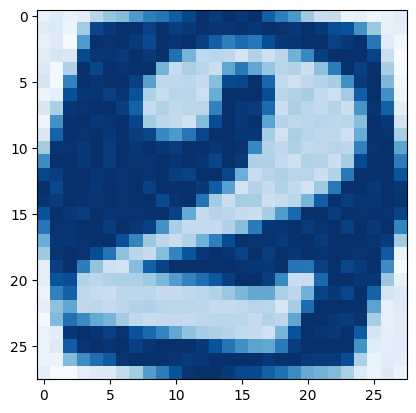

In [ ]:
img=train_images[0]
img=img.reshape(28,28)
plt.imshow(img,cmap='Blues')

In [ ]:
# import matplotlib.pyplot as plt

# # Преобразуйте исходные изображения для вывода
# train_images_reshaped = [img.reshape(28, 28) for img in train_images[15420:15427]]

# # Создайте фигуру с семью подграфиками
# fig, axes = plt.subplots(1, 7, figsize=(20, 20))

# # Выведите каждое преобразованное изображение на отдельном подграфике
# for i in range(7):
#     axes[i].imshow(train_images_reshaped[i], cmap='Gray')
#     axes[i].axis('off')

# plt.show()

In [ ]:
#prepare the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator=make_generator_model()  #calling generator function
generator

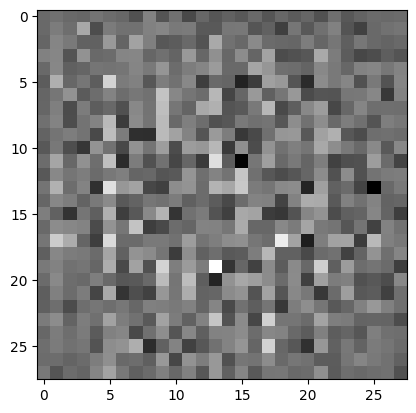

In [ ]:
noise=tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 100
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 10
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
Batch_Size=4096
@tf.function
def train_step(images):
  noise=tf.random.normal([Batch_Size,noise_dim])
  # start the training by putting noise to generator and then calculate the loss of both generator and discriminator
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    #Calculate gradients of generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,A
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def plot_metrics(metric_name, title, ylabel, train_data, val_data, yscale='linear'):
    plt.figure()
    plt.yscale(yscale)
    plt.plot(train_data, label='Training ' + metric_name)
    plt.plot(val_data, label='Validation ' + metric_name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy(acc_data, title, ylabel):
    plt.figure()
    plt.plot(acc_data, label='Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
import time
from IPython import display

def train_old(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
from sklearn.metrics import accuracy_score

def train(dataset, epochs):
    train_loss_results = []
    val_loss_results = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        train_loss_results.append(gen_loss)
        val_loss_results.append(disc_loss)

        noise=tf.random.normal([1,100])

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Plot loss and accuracy graphs
    plot_metrics('Generator Loss', 'Training and Validation Generator Loss', 'Loss', train_loss_results, val_loss_results)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
    plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
train(train_dataset, EPOCHS)

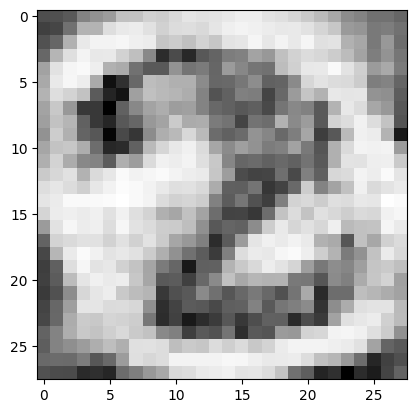

In [ ]:
noise=tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
epochs = 6000
batch_size = 4096
noise_dim = 100
num_example_to_generate = 10
reshape = 28

result = train(epochs,
               batch_size,
               noise_dim,
               )